In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

I don't think this has the bootstrapping 

In [14]:
# data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0) #demo one matteo used
data = pd.read_csv("construct_ggm/pet_graphs/adni/adni_amy_tau_merged_cent_low_quartile.csv",index_col=0)
data.sample(3)

,SUPRAMARGINAL,AMYGDALA,MIDDLETEMPORAL,PARSOPERCULARIS,CAUDALANTERIORCINGULATE,INSULA,MEDIALORBITOFRONTAL,ENTORHINAL,PUTAMEN,PERICALCARINE,...,POSTERIORCINGULATE,SUPERIORTEMPORAL,FUSIFORM,PARACENTRAL,CEREBELLUM_CORTEX,PARAHIPPOCAMPAL,BANKSSTS,POSTCENTRAL,HIPPOCAMPUS,SUPERIORFRONTAL
RID,,,,,,,,,,,,,,,,,,,,,
6244,1.272,1.434,1.357,1.161,1.016,1.158,1.174,1.599,1.992,0.812,...,1.005,1.184,1.273,1.184,0.984,1.251,1.034,1.046,1.218,1.224
6581,1.135,1.057,1.182,1.145,0.947,1.022,1.038,1.212,1.648,0.871,...,1.049,1.136,1.152,1.008,0.990,1.070,1.092,1.024,1.338,1.081
6080,1.282,1.395,1.359,1.278,1.100,1.331,1.291,1.327,1.840,0.995,...,1.222,1.260,1.324,1.285,1.035,1.298,1.249,1.244,1.247,1.252


In [15]:
#check if centiloids col is there and drop it 
# data["CENTILOIDS"]
data = data.drop(columns="CENTILOIDS")
print(data.columns)

Index(['SUPRAMARGINAL', 'AMYGDALA', 'MIDDLETEMPORAL', 'PARSOPERCULARIS',
       'CAUDALANTERIORCINGULATE', 'INSULA', 'MEDIALORBITOFRONTAL',
       'ENTORHINAL', 'PUTAMEN', 'PERICALCARINE', 'ROSTRALANTERIORCINGULATE',
       'PRECUNEUS', 'THALAMUS', 'CAUDALMIDDLEFRONTAL', 'ACCUMBENS_AREA',
       'ISTHMUSCINGULATE', 'FRONTALPOLE', 'PARSTRIANGULARIS',
       'ROSTRALMIDDLEFRONTAL', 'SUPERIORPARIETAL', 'CAUDATE', 'LINGUAL',
       'LATERALORBITOFRONTAL', 'LATERALOCCIPITAL', 'PARSORBITALIS',
       'VENTRALDC', 'PRECENTRAL', 'TEMPORALPOLE', 'INFERIORPARIETAL',
       'TRANSVERSETEMPORAL', 'CUNEUS', 'PALLIDUM', 'INFERIORTEMPORAL',
       'POSTERIORCINGULATE', 'SUPERIORTEMPORAL', 'FUSIFORM', 'PARACENTRAL',
       'CEREBELLUM_CORTEX', 'PARAHIPPOCAMPAL', 'BANKSSTS', 'POSTCENTRAL',
       'HIPPOCAMPUS', 'SUPERIORFRONTAL'],
      dtype='object')


In [16]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [17]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [18]:
alphas = np.linspace(0.015,1.,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
    model.fit(data_scaled)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

100%|██████████| 64/64 [00:01<00:00, 63.61it/s]


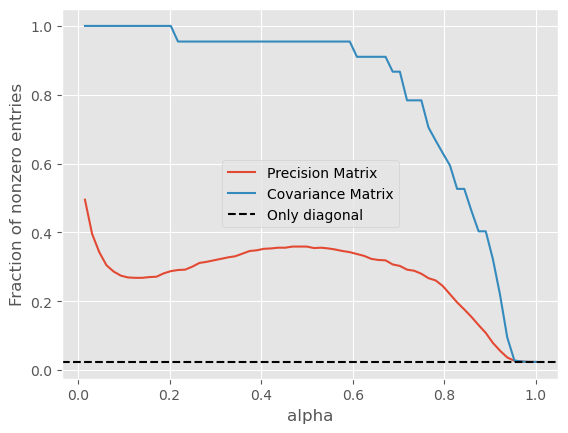

In [19]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend();

# Make graphs

In [20]:
model = GraphicalLasso(alpha=0.7, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
model.fit(data_scaled)

GraphicalLasso(alpha=0.7, assume_centered=True, eps=1e-12, max_iter=1000,
               tol=0.01)

Text(0.5, 1.0, 'Covariance')

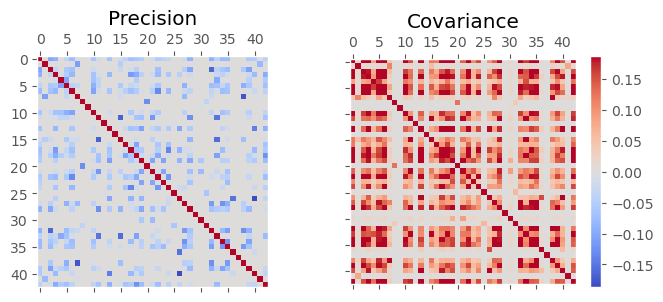

In [21]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)

im = axs[0].matshow(model.precision_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[0].grid()
# plt.colorbar(im,ax=axs[0])
axs[0].set_title("Precision")
# axs[0].axis('off')

im = axs[1].matshow(model.covariance_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[1].grid()
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Covariance")
# axs[1].axis('off')

In [22]:
adj = np.copy(model.precision_)

np.fill_diagonal(adj, 0) # remove self connections 

G = nx.Graph(adj)

node_labels = {i: label.rsplit('_',1)[0] for i, label in enumerate(data_scaled.columns)}

G = nx.relabel_nodes(G, node_labels)


In [23]:
G.degree

DegreeView({'SUPRAMARGINAL': 25, 'AMYGDALA': 3, 'MIDDLETEMPORAL': 20, 'PARSOPERCULARIS': 23, 'CAUDALANTERIORCINGULATE': 8, 'INSULA': 24, 'MEDIALORBITOFRONTAL': 24, 'ENTORHINAL': 7, 'PUTAMEN': 2, 'PERICALCARINE': 1, 'ROSTRALANTERIORCINGULATE': 19, 'PRECUNEUS': 15, 'THALAMUS': 1, 'CAUDALMIDDLEFRONTAL': 18, 'ACCUMBENS': 0, 'ISTHMUSCINGULATE': 15, 'FRONTALPOLE': 11, 'PARSTRIANGULARIS': 19, 'ROSTRALMIDDLEFRONTAL': 21, 'SUPERIORPARIETAL': 20, 'CAUDATE': 1, 'LINGUAL': 18, 'LATERALORBITOFRONTAL': 22, 'LATERALOCCIPITAL': 7, 'PARSORBITALIS': 14, 'VENTRALDC': 2, 'PRECENTRAL': 8, 'TEMPORALPOLE': 15, 'INFERIORPARIETAL': 20, 'TRANSVERSETEMPORAL': 0, 'CUNEUS': 3, 'PALLIDUM': 2, 'INFERIORTEMPORAL': 13, 'POSTERIORCINGULATE': 14, 'SUPERIORTEMPORAL': 17, 'FUSIFORM': 20, 'PARACENTRAL': 2, 'CEREBELLUM': 0, 'PARAHIPPOCAMPAL': 9, 'BANKSSTS': 19, 'POSTCENTRAL': 11, 'HIPPOCAMPUS': 2, 'SUPERIORFRONTAL': 23})

In [24]:
# Create a colormap for node colors based on node degrees
# node_colors = list(node_degrees.values())

Identify and drop the nodes with no connections

In [25]:
isolates = list(nx.isolates(G))
isolates

['ACCUMBENS', 'TRANSVERSETEMPORAL', 'CEREBELLUM']

In [26]:
G.remove_nodes_from(isolates)

In [27]:
connected_components = list(nx.connected_components(G))
len(connected_components)

2

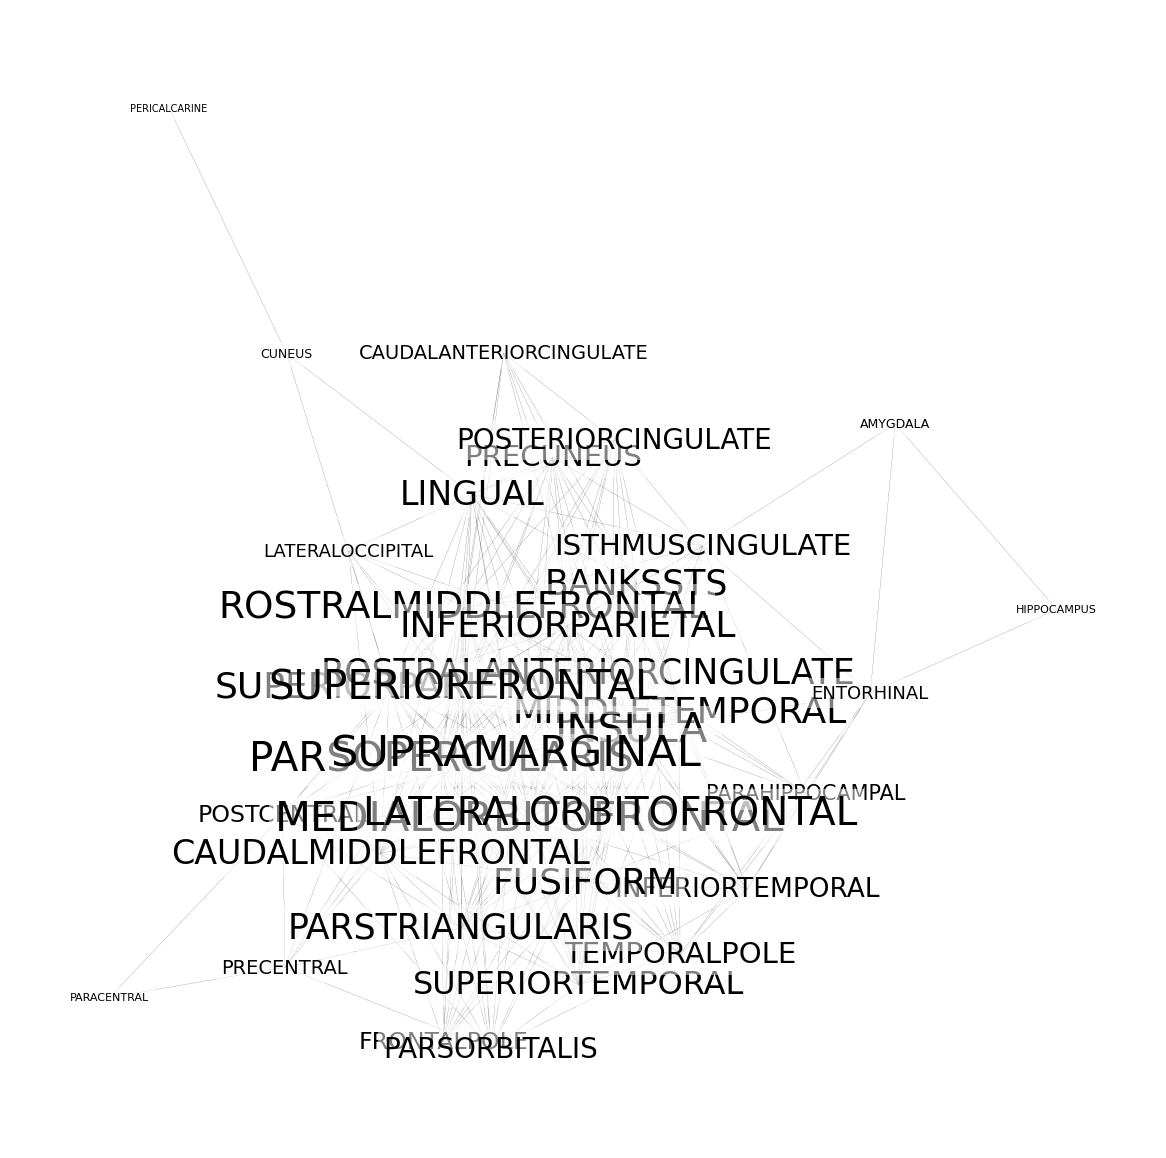

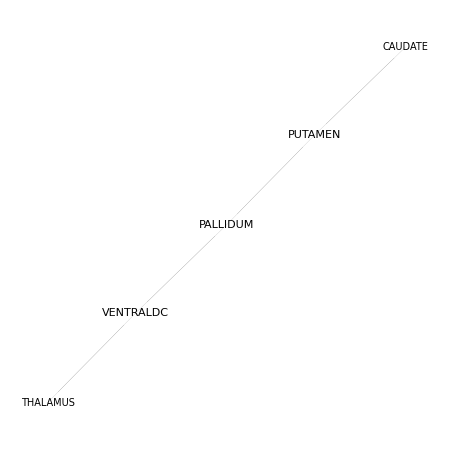

In [28]:
#  Draw the graph with node sizes and colors

for component in connected_components:

    g = G.subgraph(component)

    node_degrees = dict(g.degree())
    node_sizes = [64 * node_degrees[node] for node in g.nodes()]

    L = np.sqrt(len(component))*2.5

    fig,ax = plt.subplots(1,1,figsize=(L,L))
    pos = nx.circular_layout(g)
    pos = nx.kamada_kawai_layout(g,pos=pos,weight=None)
    # pos = nx.spring_layout(g,k=.6,pos=pos,weight=None)

    for node in component:
        nx.draw_networkx_labels(
            G.subgraph(node),
            pos={node:pos[node]},
            font_size=6+G.degree[node],
            bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
            ax=ax
        )

    nx.draw_networkx_edges(
        g,
        pos,
        width=0.1,
        # style='dashed',
        ax=ax
    )

    ax.axis('off');

# Hubs
Let's take a look at nodes that are highly connected. Do they form triangles?

In [29]:
pos = nx.kamada_kawai_layout(G["META_TEMPORAL"])

KeyError: 'META_TEMPORAL'

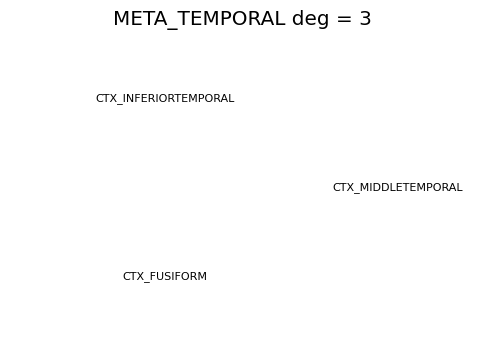

In [ ]:
for node, degree in G.degree:
    
    if degree > 1:

        fig,ax = plt.subplots(1,1,figsize=(6,4))

        g = G.subgraph(G.neighbors(node))

        pos = nx.circular_layout(g)
        # pos = nx.kamada_kawai_layout(g,pos,weight=None)

        for n in g:
            nx.draw_networkx_labels(
                G.subgraph(n),
                pos={n:pos[n]},
                # font_size=6+G.degree[n],
                font_size=8,
                bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
                # ax=ax
            )

        nx.draw_networkx_edges(
            g,
            pos,
            width=.2,
            # style='dashed',
            # ax=ax
        )

        ax.set_xlim(left=-1.5,right=1.5)
        ax.set_ylim(bottom=-1.5,top=1.5)
        
        ax.set_title(node+" deg = "+str(degree))
        ax.axis('off')